# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np
%load_ext autoreload
%autoreload 2

initializing ocelot...


### Define the linac and beams

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 42e-6 # [m]
driver.z_offset = 300e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 10000
driver.jitter.x = 0e-9 # [m]
driver.jitter.y = 0e-9 # [m]

# define stage
stage = StageQuasistatic2d()
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 5 # [m]
stage.plasma_density = 7e21 # [m^-3]
stage.ramp_beta_mag = 5

# define first stage (half length)
first_stage = StageQuasistatic2d()
first_stage.driver_source = stage.driver_source
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
source.rel_energy_spread = 0.1
source.bunch_length = 18e-6 # [m]
source.z_offset = -36e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 5000
source.jitter.t = driver.jitter.t

# define interstage
interstage = InterstageBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulations

In [3]:
linac.run('linac_example', num_shots=1, overwrite=False, parallel=False);

Tracking element 1 (s = 0.0 m, -1.60 nC, 5.0 GeV, SourceBasic, stage 0)


/pfs/lustrep4/users/lindstrm/.pyvenv/lib/python3.9/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))


Tracking element 2 (s = 2.5 m, -1.60 nC, 21.3 GeV, StageQuasistatic2d, stage 1)
Tracking element 3 (s = 9.4 m, -1.60 nC, 21.3 GeV, InterstageBasic, stage 1)
Tracking element 4 (s = 14.4 m, -1.60 nC, 52.7 GeV, StageQuasistatic2d, stage 2)
Tracking element 5 (s = 25.4 m, -1.60 nC, 52.7 GeV, InterstageBasic, stage 2)
Tracking element 6 (s = 30.4 m, -1.60 nC, 84.2 GeV, StageQuasistatic2d, stage 3)
Tracking element 7 (s = 44.4 m, -1.60 nC, 84.2 GeV, InterstageBasic, stage 3)
Tracking element 8 (s = 49.4 m, -1.60 nC, 116.1 GeV, StageQuasistatic2d, stage 4)
Tracking element 9 (s = 65.7 m, -1.60 nC, 116.1 GeV, InterstageBasic, stage 4)
Tracking element 10 (s = 70.7 m, -1.60 nC, 147.8 GeV, StageQuasistatic2d, stage 5)
Tracking element 11 (s = 89.2 m, -1.60 nC, 147.8 GeV, InterstageBasic, stage 5)
Tracking element 12 (s = 94.2 m, -1.60 nC, 179.7 GeV, StageQuasistatic2d, stage 6)
Tracking element 13 (s = 114.5 m, -1.60 nC, 179.7 GeV, InterstageBasic, stage 6)
Tracking element 14 (s = 119.5 m, -1.

### Plot the wakefield

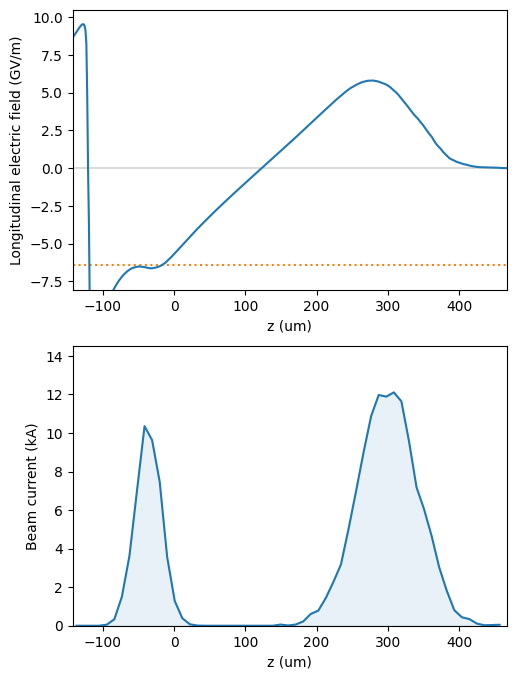

In [4]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

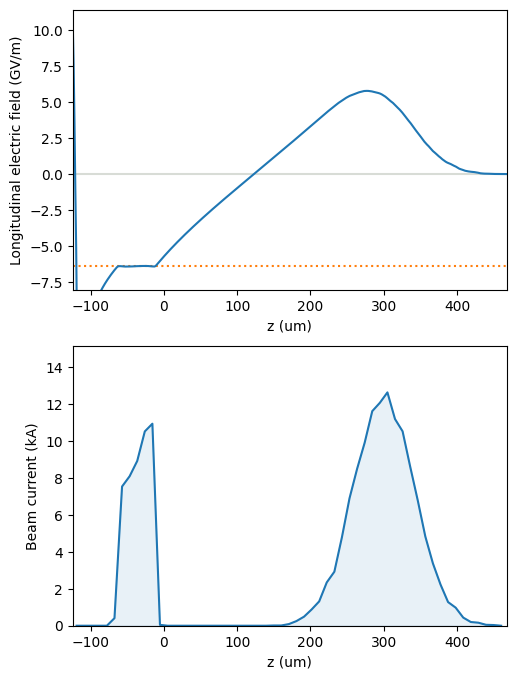

In [5]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

### Plot beam evolution and survey

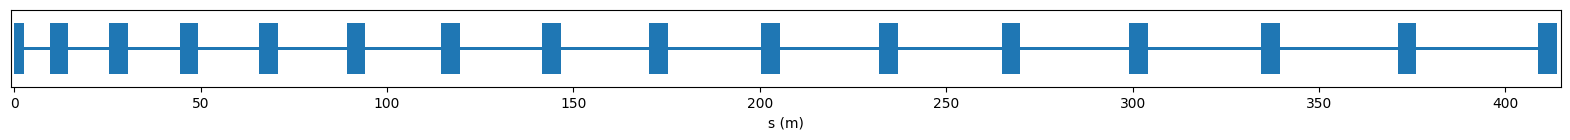

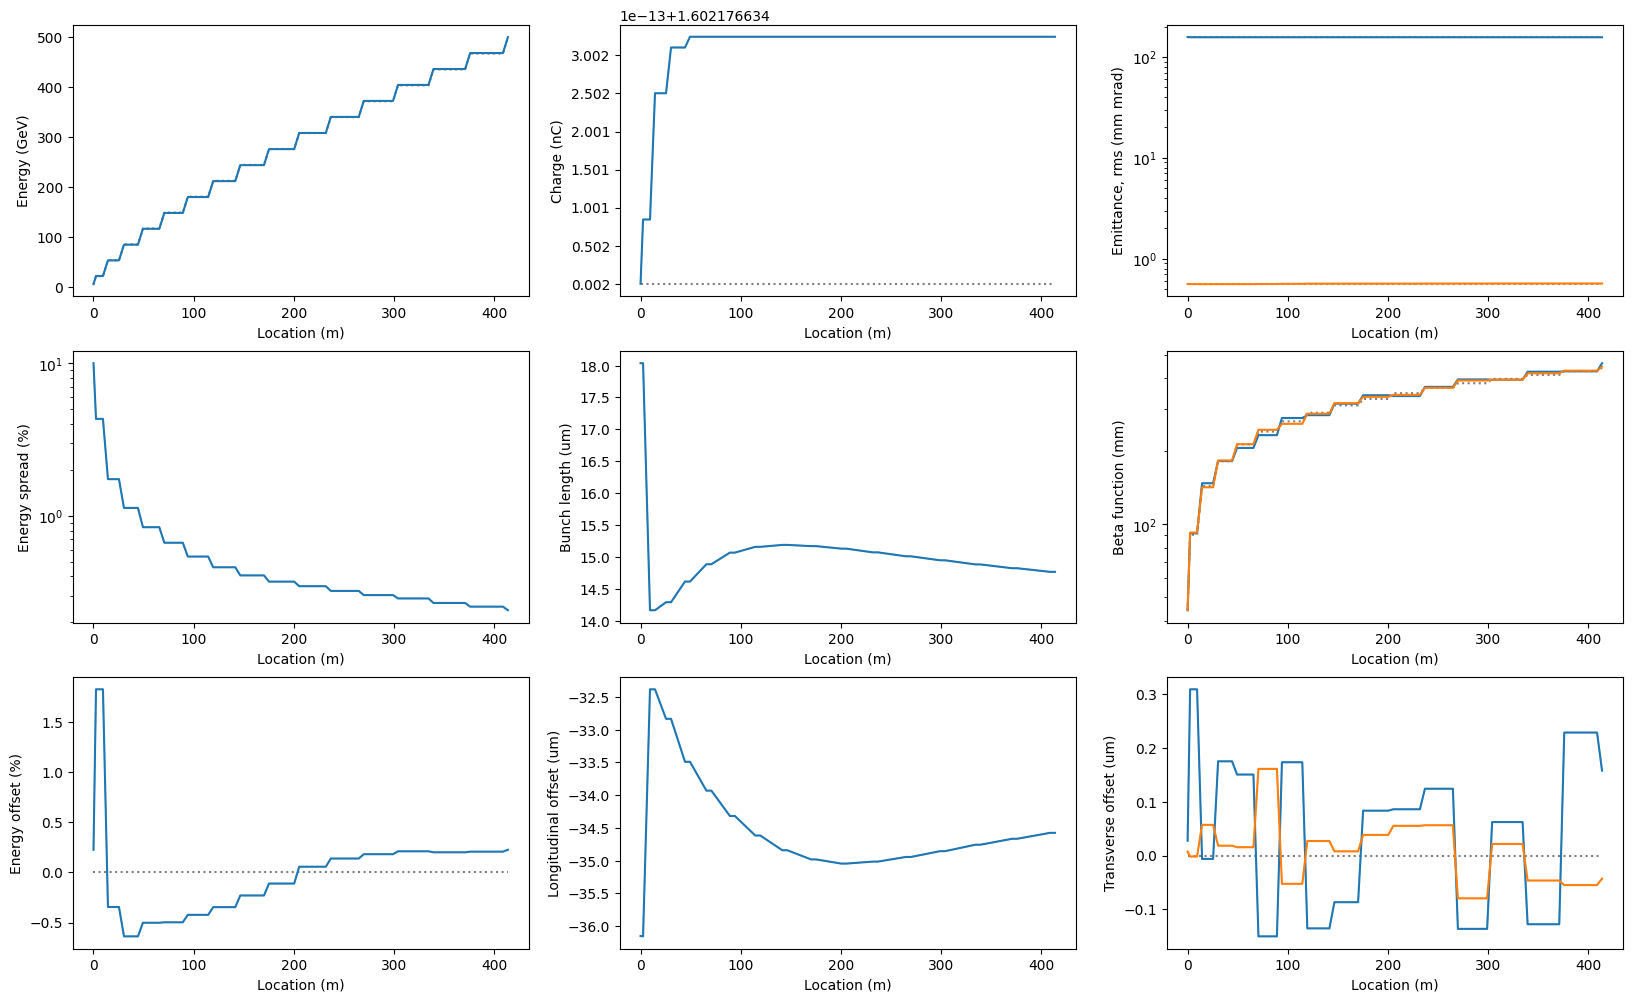

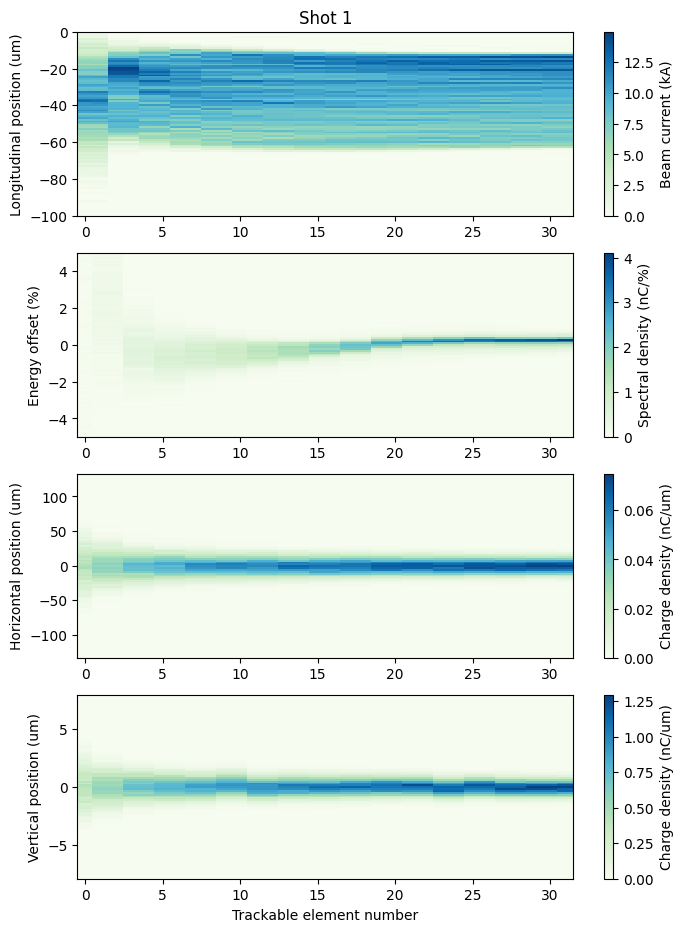

In [6]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution(use_stage_nums=False)
linac[0].plot_waterfalls()

In [24]:
linac.animate_lps()

'run_data/linac_example/plots/lps_shot0.gif'

![](run_data/linac_example/plots/lps_shot0.gif)